In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import my_funcs as my

In [2]:
torch.cuda.is_available()
cpu = torch.device('cpu')
gpu = torch.device('cuda:0')

In [ ]:
def banana(x1,x2):
    return torch.exp(-0.5*(0.01*x1**2+ 0.1*(x2+ 0.1*x1**2 -10)**2))

## Experimental setup

generate targets in a number of dimensions

In [3]:
Ds = [1,2,10,100]
Ns = [1+d for d in Ds]
num_iters = [1000*d for d in Ds]
eta = 1e-2

num_runs = 10


names = ['linear svgd','rbf svgd','gpf']

data_path = os.path.join(os.getcwd(), 'data')

In [4]:
for m in range(num_runs):
    
    for i,D in enumerate(Ds):
        #setup a standard normal distribution for the given dimension
        standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))

        #generate a random multivariate gaussian target
        target_mean = standard_normal.sample()
        target_covariance = my.random_covariance(D)
        p = torch.distributions.MultivariateNormal(target_mean,target_covariance)

        #sample initial particle positions x0
        x0 = standard_normal.sample([Ns[i]])
    
        #run each algorithm
    
        x_gpf = my.gpf(x0,p,num_iter = num_iters[i],eta1 = eta, eta2 = eta, history = False)
        x_lin = my.svgd(x0,p,num_iter = num_iters[i],kernel = 'linear',eps = eta, history = False)
        x_rbf = my.svgd(x0,p,num_iter = num_iters[i],kernel = 'rbf',eps = eta, history = False)
        
        #
        
        run_name = os.path.join(data_path,'run_{}_dim_{}'.format(m+1,D))
        if not os.path.exists(run_name):
            os.mkdir(run_name)
        
        torch.save(p,os.path.join(run_name,'target'))
        torch.save(x0,os.path.join(run_name,'x0'))
        torch.save(x_gpf,os.path.join(run_name,'x_gpf'))
        torch.save(x_lin,os.path.join(run_name,'x_lin'))
        torch.save(x_rbf,os.path.join(run_name,'x_rbf'))
        


0

## blub

pyro

In [4]:
import pyro

Generate random covariance matrices

In [45]:
D = 2
#generate diagonal matrix with eigenvalues in the desired range (i.e. [1e-1,1e1])
B = torch.eye(D) * torch.distributions.Uniform(0.1,10).sample([D])
#generate a random unitary matrix (use QR decomposition to obtain)
Q,R = torch.qr(torch.rand([D,D]))
#obtain the desired covariance by multiplication:
sigma = torch.mm(torch.mm(Q,B),Q.T)

In [61]:
print(torch.allclose(Q,Q.T))
print(torch.allclose(sigma,sigma.T))
print(torch.det(sigma) > 0)
print(torch.allclose(Q@Q.T,torch.eye(D),atol = torch.finfo(torch.float).eps))

True
True
tensor(True)
True


In [46]:
def random_cov(D,Lmin=0.1,Lmax=10):
    #generate diagonal matrix with eigenvalues in the desired range (i.e. [1e-1,1e1])
    L = torch.eye(D) * torch.distributions.Uniform(Lmin,Lmax).sample([D])
    #generate a random unitary matrix (use QR decomposition to obtain)
    Q,R = torch.qr(torch.rand([D,D]))
    #obtain the desired covariance by multiplication:
    sigma = torch.mm(torch.mm(Q,L),Q.T)
    return sigma

some utility functions

In [13]:
#generate a sample from the empirical distribution (in GPF, but potentially in svgd aswell?)
def generate_sample(x):
    N = x.shape[0]
    D = x.shape[1]
    M0 = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    m = torch.mean(x,0)
    return(1/torch.sqrt(torch.as_tensor(N,dtype=float)))*torch.sum((x-m)*M0.sample([N]),0)+m

#empirical covariance formula (could use numpy instead)
def estimate_cov(x):
    N = x.shape[0]
    m = torch.mean(x,0)
    assert N > 1
    return torch.mm((x-m).T,(x-m))/(N)

#efficient implementation of squared distance calculation (faster than cdist**2)
def squared_distance(x):
    norm = (x ** 2).sum(1).view(-1, 1)
    dist_mat = (norm + norm.view(1, -1)) - 2.0 * torch.mm(x , x.t())
    return dist_mat

Implementing GPF using torch

In [4]:
def gpf(x,num_iter=1000,eta1=0.1,eta2=0.1):
    for j in range(num_iter):
        #calculate score
        x.requires_grad = True
        log_px = -p.log_prob(x) 
        log_px.sum().backward(retain_graph = True)
        #compute g and g_
        g = x.grad
        g_ = torch.mean(g,0)
        #center the particles
        x_m = x - torch.mean(x,0)
        #calculate Matrix A particle-wise
        a = torch.zeros([D,D])
        for i in range(N):
            a += torch.mm(g[i].view(D,1),x_m[i].view(1,D))
        A = a/N - torch.eye(D)
        #update particles
        x_new = x - eta1*g_.view(1,D) - eta2*torch.mm(x_m,A) 

        x = x_new.clone().detach()
    return x



In [5]:
D = 3
target_mean = torch.full([D],3,dtype=torch.float)
#target_mean = torch.Tensor([-10.,-1.])
target_covariance = torch.eye(D)*2
#target_covariance = torch.Tensor([[5,2],[2,5]])

#target distribution p(x)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
#initial distribution q0(x)
q0 = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
#number of particles to sample from q0
N = 4
#number of iterations
num_iter = 100
#step size
eta1 = 0.1
eta2 = 0.1

In [6]:
x0 = q0.sample([N])
x = gpf(x0,num_iter,eta1,eta2)

In [7]:
m = torch.mean(x,0)
c = estimate_cov(x)

In [8]:
print(m.allclose(target_mean,atol=1e-3))
print(c.allclose(target_covariance,atol=1e-3))


False
True


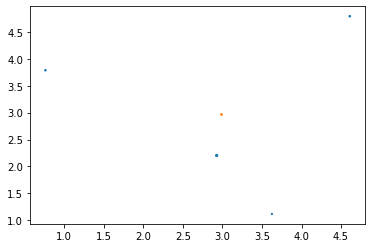

In [9]:
plt.scatter(*x.T)
plt.scatter(*m.T)


Implementing svgd in torch

In [3]:
def rbf_kernel(x,h=-1):
    #number of particles
    N = x.shape[0]
    #number of dimensions
    D = x.shape[1]
    #pairwise squared euclidean distances
    dist_mat = squared_distance(x)
    #if no proper bandwidth is given
    if h < 0:
        #use the heuristic from liu&wang2016
        h = torch.median(dist_mat)/torch.log(torch.FloatTensor([N+1]))
    #rbf kernel formula
    kxx = torch.exp(-dist_mat/h)
    #vectorized form of the derivative of the rbf kernel
    dxkxx = (-torch.mm(kxx,x)+kxx.sum(1).view(-1,1)*x)*(2/h)
    return kxx, dxkxx


def linear_kernel(x):
    N = x.shape[0]
    #D = x.shape[1]
    kxx = torch.mm(x,x.T)+torch.ones([N,N])
    dkxx = (N+1) * x
    return kxx, dkxx

def svgd(x0,p,kernel,num_iter):
    x = x0.clone().detach()
    N = x.shape[0]
    D = x.shape[1]
    x_history = torch.zeros((num_iter,N,D))
    for it in range(num_iter):
        x_history[it] = x.clone().detach()
        #enable autograd for x
        x.requires_grad = True
        
        #calculate kernel and kernel_gradient
        if kernel == 'rbf':
            kxx,dkxx = rbf_kernel(x)
        if kernel == 'linear':
            kxx,dkxx = linear_kernel(x)
        #calculate the log-likelihood of x
        logpx = p.log_prob(x)
        #calculate the derivative of the log-likelihood wrt x
        logpx.sum().backward(retain_graph = True)
        dxlogpx = x.grad.clone()
        #zero x.grad for later use
        x.grad.data.zero_()    
        #calculate optimal perturbation direction
        phi = (1/N) * (torch.mm(kxx,dxlogpx) + dkxx)
        #make a step of gradient descent
        x_new = x + eps* phi
        x = x_new.clone().detach()
    return x,x_history

In [9]:
D = 2
target_mean = torch.full([D],3,dtype=torch.float)
#target_mean = torch.Tensor([3.,1.])
target_covariance = torch.eye(D)*2
#target distribution p(x)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
#initial distribution q0(x)
q0 = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
#number of particles to sample from q0
N = 3
#number of iterations
num_iter = 1000
#step size
eps = 1e-2
kernel = 'rbf'

In [10]:
#initialize N particles from q0
x0 = q0.sample([N])
#copy them to the variable I want to work with (probably unneccessary)
x = x0.clone().detach()

In [ ]:
ext_kxx = torch.zeros([N,N])
ext_dkxx = torch.zeros([N,N,D])
ext_dlogpx = torch.zeros([N,N,D])



for it in range(num_iter):
    #enable autograd for x
    x.requires_grad = True
    
    if kernel == 'rbf':
        dist_mat = squared_distance(x)
        h = torch.median(dist_mat)/torch.log(torch.FloatTensor([N+1]))
        
    x_new = torch.zeros((N,D))
    #for each particle determine update individually
    for i in range(N):
        phi = torch.zeros([1,D])
        #determine contribution of each other particle individually
        for j in range(N):
            #calculate the log-likelihood of xj
            logpx = p.log_prob(x[j])
            #calculate the derivative of the log-likelihood wrt xj
            logpx.sum().backward(retain_graph = True)
            dxlogpx = x.grad[j].clone()
            ext_dlogpx[i,j] = dxlogpx
            #zero x.grad for later use
            x.grad.data.zero_()
            
            if kernel == 'linear':
                #determine (linear) kernel contribution
                kxx = x[i].view(1,-1) @ x[j].view(-1,1) + 1
                #determine linear kernel derivative wrt xj
                
                kxx.backward(retain_graph = True)
                dkxx = x.grad[j].clone()

                ext_kxx[i,j] = kxx
                ext_dkxx[i,j] = dkxx
                
                x.grad.data.zero_()
                    
            elif kernel == 'rbf':
                #determine (rbf) kernel contribution
                kxx = torch.exp((-1/h) * dist_mat[j,i])
                #determine rbf kernel derivative
                dkxx = (-2/h) * kxx * (x[j] - x[i])
                
                ext_kxx[j,i] = kxx
                ext_dkxx[j,i] = dkxx
            #determine optimal perturbation direction wrt xj

            phi += kxx*dxlogpx + dkxx #_auto
        phi *= (1/N)
        x_new[i] = x[i] + eps* phi
    x = x_new.clone().detach()

theta = x.clone()

In [ ]:
x_svgd,_ = svgd(x0,p,kernel,num_iter)

In [130]:
print(torch.mean(x_svgd,0))
print(estimate_cov(x_svgd))

tensor([2.8717, 2.8716])
tensor([[3.0510, 0.3843],
        [0.3843, 3.0510]])


In [54]:
print(x0)
x_test = x0.clone().detach()
x_test.requires_grad = True

tensor([[ 1.8423,  0.1212],
        [ 0.8713, -0.1863],
        [-0.7568,  1.0121]])


In [55]:
logpx_test = p.log_prob(x_test)
logpx_test.sum().backward(retain_graph = True)
dxlogpx_test = x_test.grad.clone()
x_test.grad.data.zero_()

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [56]:
kxx_test = torch.mm(x_test,x_test.T)+torch.ones([N,N])

In [57]:
kxx_test.allclose(ext_kxx)

True

In [64]:
dkxx_test = torch.zeros([N,D])
for i in range(N):
    for j in range(N):
        kxx_test[i,j].backward(retain_graph = True)
        dkxx_test[i] += x_test.grad[j].clone()
        x_test.grad.data.zero_()

In [100]:
dkxx_test = torch.zeros([N,D])
for i in range(N):
    for j in range(N):
        if i == j:
            dkxx_test[i] += 2*x[i]
        else:
            dkxx_test[i] += x[i]

In [111]:
ext_dkxx.mean(1)

tensor([[ 2.4564,  0.1616],
        [ 1.1618, -0.2484],
        [-1.0091,  1.3495]])

In [107]:
x_new_test = x_test + eps * (1/N)*(kxx_test@dxlogpx_test + dkxx_test)

In [108]:
x_new_test.allclose(x)

False

In [99]:
dxlogpx_test.allclose(ext_dlogpx)

True

In [100]:
ext_kxx.allclose(kxx_test)

True

Getting familiar with probability distributions in torch

In [ ]:
D = 2
m = 0
mean = torch.ones(D) * m
covariance = torch.eye(D)
p = torch.distributions.MultivariateNormal(mean, covariance)

In [ ]:
N = 100
samples = p.sample(torch.Size([N]))
x,y = samples[:,0],samples[:,1]
plt.scatter(x,y)
plt.axis('square')
plt.show()